In [1]:
import pandas as pd
import os
import numpy as np
import gspread
ROOTFOLDER = "D:/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was/_data"
RAW = f"{ROOTFOLDER}/_raw"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated/c_analysis"


# Goal: visualize basic statistics
1. Get mean {SVF} per each city per yeargroup
2. Plot road fatality and dalys per country

In [2]:
FILENAME_CROSS = "01_seg_dalys_cross.csv"
y = ['diabetes_mellitus_cap', 'mental_and_substance_use_disorders_cap',
       'cardiovascular_diseases_cap', 'road_injury_cap','num_person_killed_per_lakh']

crossdf = pd.read_csv(os.path.join(CURATED_FOLDER, FILENAME_CROSS))

# set up conditions
condition = (crossdf['person_count']>0)&(crossdf['road']>0)&(crossdf['res']==9)
crossdf_city = crossdf[condition].groupby(['country_clean', 'city_lower']).mean().reset_index()

In [192]:
# crossdf_country = crossdf[condition].groupby(['country_clean']).mean().reset_index()
# # plot the dalys from road injury first
# crossdf_country = crossdf_country[y+['country_clean']].sort_values(by='road_injury_cap', ascending=False)


In [7]:
# temporary merge the gdp
CURATED_FOLDER = "D:/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was/_data/_curated/c_city_profiles"
gdp = pd.read_csv(os.path.join(CURATED_FOLDER, "c_city_gdp.csv"))
gdp["city_lower"] = gdp["City"].apply(lambda x: x.lower().replace(" ", ""))
crossdf_city_merge = crossdf_city.merge(gdp, on=['city_lower','country_clean'], 
                                        how='inner')

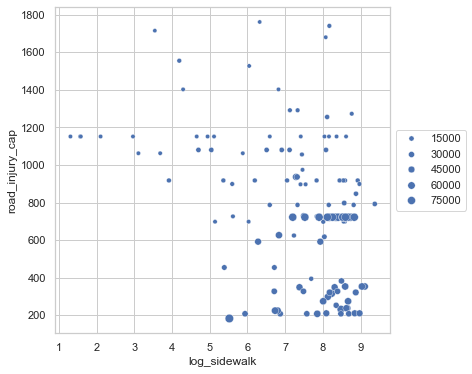

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.scatterplot(data=crossdf_city_merge, 
                x='log_sidewalk', 
                y='road_injury_cap', 
                size = 'gdp_per_cap_country_2022',
                # hue='country_clean'
                )
# take legend out
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

<Figure size 432x432 with 0 Axes>

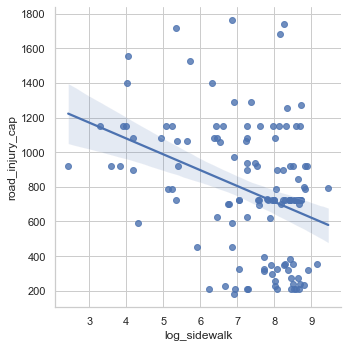

In [64]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.lmplot(data=crossdf_city, 
                x='log_sidewalk', 
                y='road_injury_cap', 
                )

In [65]:
crossdf['country_clean'].nunique()

50

<AxesSubplot:xlabel='sidewalk', ylabel='country_clean'>

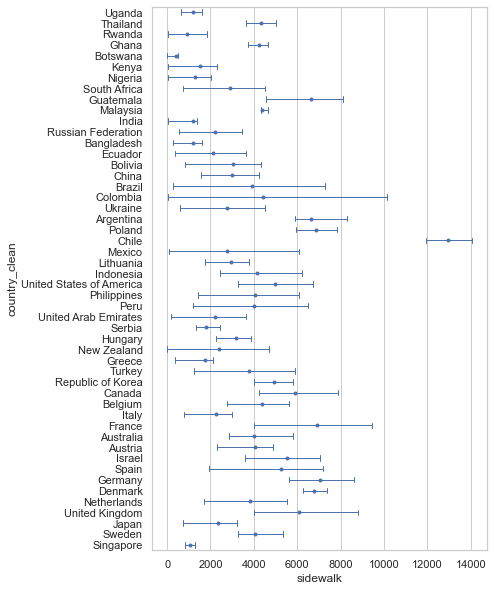

In [177]:
plt.figure(figsize=(6, 10))
# sns.boxplot(data=crossdf[condition].sort_values('road_injury_cap', ascending=False), 
#                 x='log_sidewalk', 
#                 y='country_clean', 
#                 )
viz = crossdf[condition].sort_values('road_injury_cap', ascending=False)
viz['sidewalk_person'] = viz['sidewalk']/viz['person_count']
viz['sidewalk_road'] = viz['sidewalk']/viz['road']
order = viz['country_clean'].unique()
sns.pointplot(
        data = viz,
        x='sidewalk_person',
        y='country_clean',
        order = order,
        # errorbar= 'ci',
        markersize = 4,
        errorbar = ('pi', 50),
        capsize=0.5,
        err_kws = {'linewidth':1},
        linewidth=0
        # ci = 'sd',
        
    )

<Figure size 432x432 with 0 Axes>

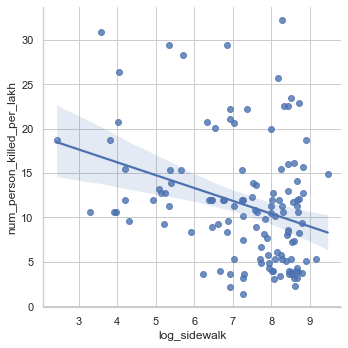

In [68]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.lmplot(data=crossdf_city, 
                x='log_sidewalk', 
                y='num_person_killed_per_lakh', )

# Summarize the longitudinal
**NOTES**
1. make sure using the same HEXGON IDS. for those do not have data in the previous years, can be dropped.

In [142]:
res = 9
FILENAME_CROSS = f"01_seg_dalys_long_res={res}.csv"
dflong = pd.read_csv(os.path.join(CURATED_FOLDER, 
                                  FILENAME_CROSS))
print(dflong.shape)
dflong = dflong.drop_duplicates().reset_index(drop = True)
print(dflong.shape)
dflong['year_count'] = dflong.groupby(['hex_id','city_lower'])['year_group'].transform('nunique')
dflong['year_count'].value_counts()

(7691625, 31)
(7691625, 31)


1    5944619
2    1747006
Name: year_count, dtype: int64

In [91]:
dflong.to_csv(os.path.join(CURATED_FOLDER,FILENAME_CROSS), index = False)

In [143]:
dflong['hex_year_count'] = dflong.groupby(['hex_id','year_group','city_lower'])['year_group'].transform('count')
dflong[dflong['hex_year_count']>1] # these are cross city

,hex_id,res,city_lower,year_group,ring,building,greenery,street_furniture,sidewalk,car,...,country_clean,urban_pop,pop_country,year,diabetes_mellitus_cap,mental_and_substance_use_disorders_cap,cardiovascular_diseases_cap,road_injury_cap,year_count,hex_year_count


In [153]:
variables = ['building', 'greenery',
       'street_furniture', 'sidewalk',  'sky', 'road',
       'car_count', 'person_count', 'bike_count',]
y_ls = ['diabetes_mellitus_cap',
       'mental_and_substance_use_disorders_cap', 
       'cardiovascular_diseases_cap',
       'road_injury_cap', 'num_person_killed_per_lakh']
spatialkeys = ['city_lower','country_clean','hex_id']
timekeys = ['year_group']
dflong_valid = dflong[(dflong['year_count']>1)&(dflong['res']==res)].reset_index(drop = True)\
    .drop_duplicates(spatialkeys+timekeys)\
    .pivot(index=spatialkeys, columns=timekeys, values=variables+y_ls).reset_index()
for v in variables:
    # the y variable cannot fill na directly.
    dflong_valid[v] = dflong_valid[v].fillna(0)

vari_change = []
### HERE USING LOG DIFFERENCE TO SHOW PERCENTAGE
for var in variables+y_ls:
    dflong_valid['diff-'+var] = np.log(dflong_valid[var]['2020-2023']+1)-np.log(dflong_valid[var]['2015-2018']+1)
    vari_change.append('diff-'+var)
dflong_valid_city = dflong_valid[vari_change+spatialkeys]\
    .groupby(['city_lower','country_clean']).mean().reset_index().reset_index().drop(columns = 'index')
dflong_valid_city.columns = ["".join(x) for x in dflong_valid_city.columns.ravel()]

C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_25000\2506348615.py:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dflong_valid_city = dflong_valid[vari_change+spatialkeys]\
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_25000\2506348615.py:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dflong_valid_city = dflong_valid[vari_change+spatialkeys]\
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_25000\2506348615.py:20: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  dflong_valid_city.columns = ["".join(x) for x in dflong_valid_city.columns.ravel()]


In [154]:
longdf = []
for var in variables+y_ls:
    temp = dflong_valid_city[['city_lower','country_clean', f'diff-{var}']].rename(columns = {f'diff-{var}':'diff'})
    temp['variable'] = var
    longdf.append(temp)
longdf = pd.concat(longdf).reset_index(drop = True)
longdf

,city_lower,country_clean,diff,variable
0,amsterdam,Netherlands,0.276490,building
1,antwerp,Belgium,0.116641,building
2,astrakhan,Russian Federation,0.372647,building
3,athens,Greece,-0.067451,building
4,auckland,New Zealand,0.194064,building
...,...,...,...,...
1395,vienna,Austria,-0.053621,num_person_killed_per_lakh
1396,warsaw,Poland,-0.021404,num_person_killed_per_lakh
1397,wellington,New Zealand,0.171998,num_person_killed_per_lakh
1398,yamaguchi,Japan,-0.103184,num_person_killed_per_lakh


In [155]:
longdf.sort_values('diff', ascending = False)

,city_lower,country_clean,diff,variable
506,bangalore,India,10.705988,road
306,bangalore,India,8.754358,sidewalk
334,hyderabad,India,6.746314,sidewalk
322,delhi,India,6.689634,sidewalk
534,hyderabad,India,6.562973,road
...,...,...,...,...
539,jerusalem,Israel,-1.346466,road
22,delhi,India,-1.543967,building
234,hyderabad,India,-2.350240,street_furniture
222,delhi,India,-5.923587,street_furniture


In [165]:
dflong_valid_city.sort_values("diff-sidewalk", ascending = False)

,city_lower,country_clean,diff-building,diff-greenery,diff-street_furniture,diff-sidewalk,diff-sky,diff-road,diff-car_count,diff-person_count,diff-bike_count,diff-diabetes_mellitus_cap,diff-mental_and_substance_use_disorders_cap,diff-cardiovascular_diseases_cap,diff-road_injury_cap,diff-num_person_killed_per_lakh
6,bangalore,India,-0.974421,0.929888,-6.137187,8.754358,-0.221686,10.705988,0.916291,-0.405465,0.223144,0.120192,0.008318,0.032895,0.015596,-0.074316
34,hyderabad,India,-0.140928,1.143124,-2.350240,6.746314,0.568809,6.562973,0.439962,0.381070,0.674963,0.120192,0.008318,0.032895,0.015596,3.042139
22,delhi,India,-1.543967,5.120253,-5.923587,6.689634,1.068206,3.254849,0.980829,-0.405465,0.000000,0.120192,0.008318,0.032895,0.015596,-0.225731
73,rajshahi,Bangladesh,0.804403,-0.252937,-0.219192,1.837391,-0.057039,1.026907,0.069717,-0.034319,0.037004,0.141056,0.032520,0.093073,0.000296,-0.028725
78,saidpur,Bangladesh,0.324442,-0.212409,-0.738105,1.799362,-0.069042,0.219559,-0.017301,-0.045276,-0.024742,0.141056,0.032520,0.093073,0.000296,-0.028725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,detroit,United States of America,-0.027674,-0.265073,0.021642,-0.203098,0.074285,0.008215,-0.001106,-0.026361,-0.001109,0.090850,0.076914,0.050783,0.009146,0.148047
16,chicago,United States of America,-0.326281,-0.316737,-0.040566,-0.305885,0.035167,-0.358926,-0.025994,-0.009786,-0.000337,0.090850,0.076914,0.050783,0.009146,0.274094
70,philadelphia,United States of America,-0.060514,-0.415997,-0.207862,-0.368614,-0.074857,-0.027578,-0.012681,-0.024438,-0.005150,0.090850,0.076914,0.050783,0.009146,0.255767
84,singapore,Singapore,0.052665,-0.007220,-0.059576,-0.413262,0.075008,-0.292475,-0.032047,-0.005005,-0.002585,0.027608,0.006532,0.142002,-0.108900,-0.210156


In [176]:
dflong_valid_city[dflong_valid_city['diff-num_person_killed_per_lakh']>2]

,city_lower,country_clean,diff-building,diff-greenery,diff-street_furniture,diff-sidewalk,diff-sky,diff-road,diff-car_count,diff-person_count,diff-bike_count,diff-diabetes_mellitus_cap,diff-mental_and_substance_use_disorders_cap,diff-cardiovascular_diseases_cap,diff-road_injury_cap,diff-num_person_killed_per_lakh
8,belohorizonte,Brazil,0.022605,0.128173,0.050119,0.063025,-0.063475,0.020187,0.002173,-0.015380,0.006182,0.078255,-0.005558,0.010056,-0.249286,2.980619
21,curitiba,Brazil,0.056227,0.110412,0.089307,0.294257,-0.042494,0.023052,0.006786,-0.021129,0.002826,0.078255,-0.005558,0.010056,-0.249286,3.198673
28,florianopolis,Brazil,0.203899,0.041963,0.223669,0.728775,-0.005098,0.043318,0.031562,-0.004148,0.012158,0.078255,-0.005558,0.010056,-0.249286,3.161247
34,hyderabad,India,-0.140928,1.143124,-2.350240,6.746314,0.568809,6.562973,0.439962,0.381070,0.674963,0.120192,0.008318,0.032895,0.015596,3.042139
35,ilheus,Brazil,0.194396,-0.101949,0.000170,0.325395,-0.011866,0.078961,0.047213,-0.016083,0.011160,0.078255,-0.005558,0.010056,-0.249286,2.980619
38,jequie,Brazil,0.183030,-0.039209,0.051850,0.137030,-0.017818,0.027372,0.035960,-0.010061,0.004622,0.078255,-0.005558,0.010056,-0.249286,2.980619
67,palmas,Brazil,0.433486,0.471886,-0.063770,0.502691,-0.019019,0.001778,0.084382,-0.052389,-0.017807,0.078255,-0.005558,0.010056,-0.249286,3.462606
75,ribeiraopreto,Brazil,0.237493,-0.027249,0.076897,0.456380,-0.035292,0.012208,0.015969,-0.028539,-0.010269,0.078255,-0.005558,0.010056,-0.249286,2.701361
76,riodejaneiro,Brazil,0.039232,0.098078,-0.118367,0.011929,0.014630,0.012115,-0.015794,-0.012130,0.019714,0.078255,-0.005558,0.010056,-0.249286,2.815409
82,saopaulo,Brazil,0.116057,0.044861,0.065168,0.268214,-0.088500,0.036419,0.011606,-0.031579,0.013164,0.078255,-0.005558,0.010056,-0.249286,2.701361


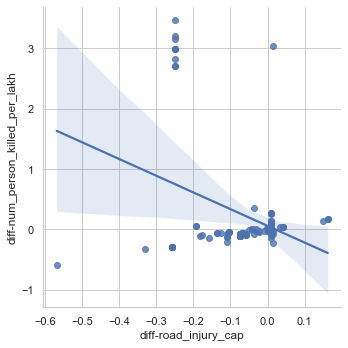

In [164]:
sns.lmplot(data=dflong_valid_city, 
                x='diff-road_injury_cap', 
                y='diff-num_person_killed_per_lakh', 
                )

In [170]:
longdf['variable'].unique()

array(['building', 'greenery', 'street_furniture', 'sidewalk', 'sky',
       'road', 'car_count', 'person_count', 'bike_count',
       'diabetes_mellitus_cap', 'mental_and_substance_use_disorders_cap',
       'cardiovascular_diseases_cap', 'road_injury_cap',
       'num_person_killed_per_lakh'], dtype=object)

900


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


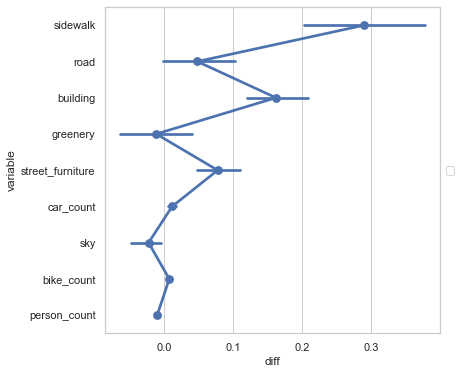

In [175]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 6))

vizcondition = longdf['variable'].isin(['building', 'greenery', 'street_furniture', 'sidewalk', 'sky',
       'road', 'car_count', 'person_count', 'bike_count'])
viz = longdf[vizcondition].reset_index(drop = True)
print(viz.shape[0])
sns.pointplot(data=viz[~viz["city_lower"].isin(['hyderabad', 'bangalore', 'delhi'])].sort_values("diff", ascending=False),
            x = 'diff',
            y  ='variable',
            hue = 'country_clean',
)
# bring the legend out
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


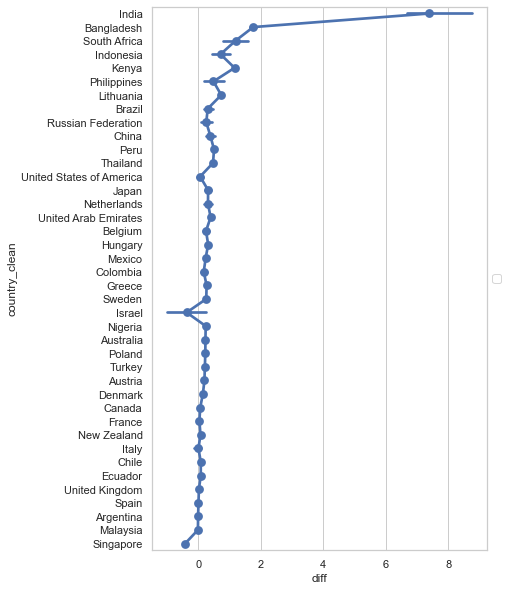

In [151]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 10))
varisel = 'sidewalk'
sns.pointplot(data=longdf[longdf['variable']==varisel].sort_values("diff", ascending=False),
            x = 'diff',
            y  ='country_clean',
            # hue = 'country_clean',
)
# bring the legend out
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [ ]:
plot_one("street_furniture", top_n = 50)

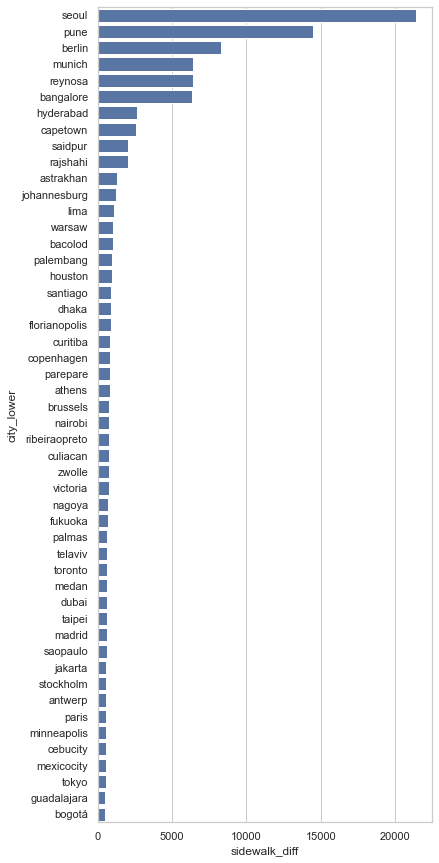

In [27]:
plot_one("sidewalk", top_n = 50)